<a href="https://colab.research.google.com/github/ddfulaa/Machine-Learning-Notes/blob/main/Machine%20Learning%20-%20Assignment%201%20-%20Classification%20-%20Abalones.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import norm

In [ ]:
#Load the data
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data'
column_names = ['sex', 'length', 'diameter', 'height', 'whole_weight', 'shucked_weight', 'viscera_weight', 'shell_weight', 'rings']
data = pd.read_csv(url, header=None, names=column_names)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sex             4177 non-null   object 
 1   length          4177 non-null   float64
 2   diameter        4177 non-null   float64
 3   height          4177 non-null   float64
 4   whole_weight    4177 non-null   float64
 5   shucked_weight  4177 non-null   float64
 6   viscera_weight  4177 non-null   float64
 7   shell_weight    4177 non-null   float64
 8   rings           4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


In [ ]:
data.describe()

,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,9.933684
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.224169
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,8.000000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,11.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


Let's add a new column called `ringClass`. We are asked to ignore the attribute sex and convert the rings attribute in a binary class label ringClass, such that  $\text{ringClass} = 1$ if $\text{rings} ≥ \text{rings}$ and $\text{ringClass} = 0$ otherwise, where $\text{rings}$ is the average value of rings for the whole dataset.

In [ ]:
df=data.copy()
rings=df['rings'].mean()
df['ringClass']=df['rings'].apply(lambda x: 1 if x>=rings else 0)
df.drop(['sex','rings'], axis=1, inplace=True)

In [ ]:
from sklearn.model_selection import train_test_split

df_train, df_valid, _ , _ = train_test_split(df, df, test_size=0.33, random_state=42)

X = df.copy().drop(['ringClass'],axis=1)
y = df.copy().pop('ringClass')

X_train, X_valid,y_train,y_valid= train_test_split(X, y, test_size=0.33, random_state=42)

# 1.
Let's build the univariate Gaussian classifiers. Since we have only two classes, we could use a single discriminant function $$g(x)= g_1(x) - g_2 (x)$$ and choose $C_1$ if $g(x) > 0$ or $C_2$ otherwise. But we will assume the distribution of the attributes is gaussian, so it would be better to choose $g$ as follows $$ g(x) = \log \dfrac{g_1(x)}{g_2(x)}$$ and choose the classes as before.
Now, replacing the discriminant functions and doing some calculations, we have $$ g(x) = -\log \sigma_1 + \log \sigma_2 - \dfrac{(x-\mu_1)^2}{2 \sigma_1^2} + \dfrac{(x-\mu_2)^2}{2 \sigma_2^2} + \log p(C_1) - \log p(C_2)$$
where $\sigma_1$, $\mu_1$, $\sigma_2$, and $\mu_2$ are the parameters of the distributions associated to $C_1$ and $C_2$.
In this case we don't know those parameters, so we have to estimate them from the data. Taking this into consideration, we could start to program our classifier. We will assume that the class $C_1$ is for the $1$ values of $y$ and $C_2$ for the $0$ values.

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
def mu(X,C):
  #return X.dot(C) / C.sum()
  return X[C==1].mean()
def sigma(X,C):
  #return np.sqrt(X.apply(lambda x: np.square(x-mu(X,C))).dot(C) / C.sum())
  return X[C==1].std()

def gaussianParameters(X,C):
  return {'m1':mu(X,C),'s1':sigma(X,C),'m2':mu(X,1-C),'s2':sigma(X,1-C)}

def gaussianClassifier_aux(X,C):
  params=gaussianParameters(X,C)
  pC1= C.sum() / C.size
  pC2= 1-pC1
  return lambda df: -np.log(params['s1'])+np.log(params['s2']) \
                    - np.square(df-params['m1']) / (2*np.square(params['s1'])) \
                    + np.square(df-params['m2']) / (2*np.square(params['s2'])) \
                    + np.log(pC1) - np.log(pC2)

def gaussianClassifier(X,C):
  params=gaussianParameters(X,C)
  pC1= C.sum() / C.size
  pC2= 1-pC1
  return lambda df: pd.Series(norm.pdf(df, params['m1'], params['s1'])*pC1 - norm.pdf(df, params['m2'], params['s2'])*pC2, index=df.index)

def evaluateClassifier(y_true,y_predict,average='binary'):
  return {'accuracy':accuracy_score(y_true,y_predict),
          'precision':precision_score(y_true,y_predict,average=average),
          'recall':recall_score(y_true,y_predict,average=average),
          'f1':f1_score(y_true,y_predict,average=average)}

def point_1(X_train,y_train,X_valid,y_valid):
  attribute_list=list(X_train.columns)
  classifiers_metrics=dict()
  classifiers_params=dict()
  for attribute in attribute_list:
    classifier=gaussianClassifier(X_train[attribute],y_train)
    params=gaussianParameters(X_train[attribute],y_train)
    y_predict= classifier(X_valid[attribute]).apply(lambda x: x>0).astype('int')
    classifiers_metrics[attribute]=evaluateClassifier(y_valid,y_predict)
    classifiers_params[attribute]=params
  return {'metrics':classifiers_metrics,'parameters':classifiers_params}

In [ ]:
results=point_1(X_train,y_train,X_valid,y_valid)

Now, we got a variable `results` which contains the values of the metrics and the parameters for each classifier.

In [ ]:
def report(results):
  metrics_df=pd.DataFrame(results['metrics'])
  params_df=pd.DataFrame(results['parameters'])
  print(f'\nParameters:\n{params_df}\nMetrics\n{metrics_df}')
report(results)  


Parameters:
      length  diameter    height  whole_weight  shucked_weight  \
m1  0.587001  0.461183  0.160729      1.093174        0.461360   
s1  0.084675  0.069531  0.029037      0.452655        0.215858   
m2  0.463943  0.356865  0.119095      0.574403        0.262761   
s2  0.118234  0.096829  0.044170      0.382795        0.184702   

    viscera_weight  shell_weight  
m1        0.237819      0.320990  
s1        0.100488      0.128495  
m2        0.125555      0.160143  
s2        0.086769      0.100848  
Metrics
             length  diameter    height  whole_weight  shucked_weight  \
accuracy   0.708484  0.726613  0.744017      0.727339        0.674402   
precision  0.662211  0.680247  0.695545      0.739771        0.691638   
recall     0.814649  0.823617  0.840060      0.675635        0.593423   
f1         0.730563  0.745098  0.761002      0.706250        0.638777   

           viscera_weight  shell_weight  
accuracy         0.708484      0.759971  
precision        0.7305

Let's compare the metrics.

In [ ]:
def plot_comparison(df,metric,title='Classifier'):
  aux=df.transpose()[metric].sort_values()
  color=['0.8']*(aux.size-1)
  color.append('r')
  ax = aux.plot(kind='barh',
             figsize=(10,8),
               color = color)
  ax.set_title(title+' '+metric.capitalize()+' Comparison')
  ax.set_xlabel(metric.capitalize())
  plt.xlim(0.6, 0.85)
  plt.show();

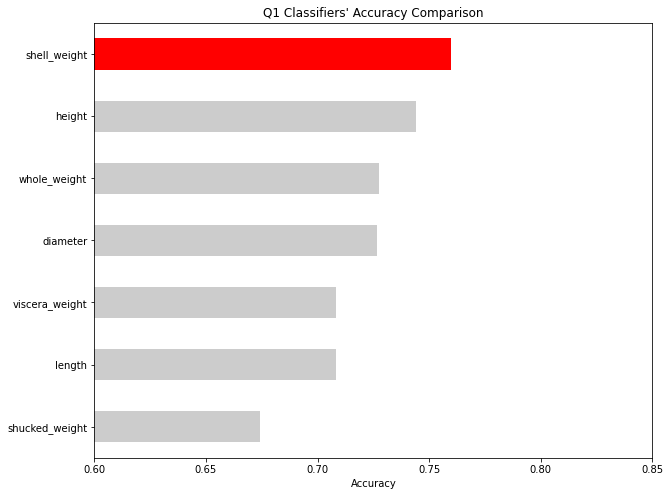

In [ ]:
compare_metrics = pd.DataFrame(results['metrics'])
plot_comparison(compare_metrics,'accuracy','Q1 Classifiers\'')

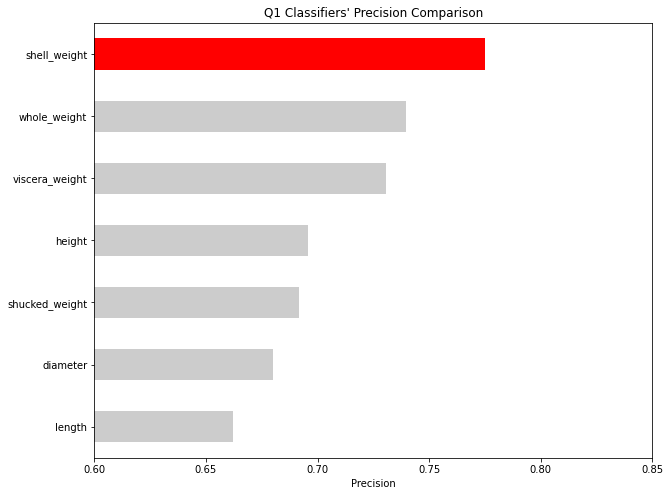

In [ ]:
plot_comparison(compare_metrics,'precision','Q1 Classifiers\'')

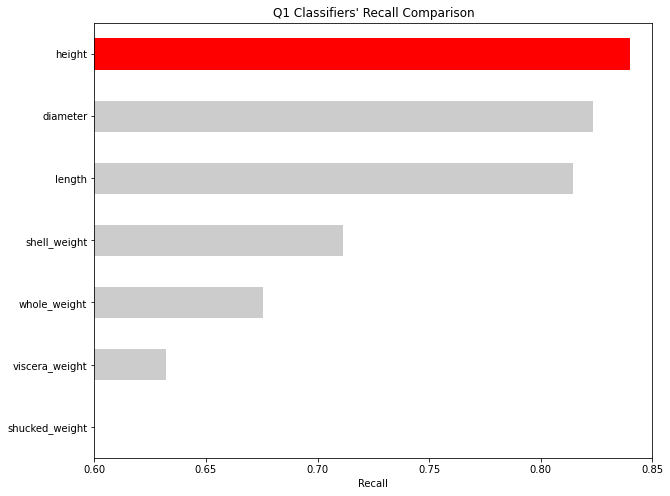

In [ ]:
plot_comparison(compare_metrics,'recall','Q1 Classifiers\'')

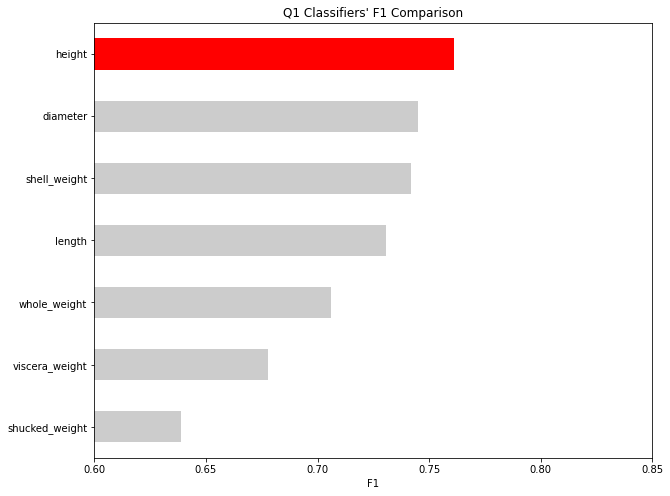

In [ ]:
plot_comparison(compare_metrics,'f1','Q1 Classifiers\'')

The selection of the best classifier is not straightforward, as different evaluation metrics lead to different results. If we consider accuracy and precision, the classifier associated with `shell_weight` performs the best. On the other hand, if we focus on recall, the classifier associated with `height` is the optimal choice. However, since the dataset is well balanced with equal representation of both classes (1412 values for class 1 and 1386 for class 2), we can prioritize accuracy. Therefore, the classifier associated with `shell_weight` is the most suitable one for our analysis.


In [ ]:
best='shell_weight'
best_parameters = results['parameters'][best]

Let's see how behaves the likelihood of each class.

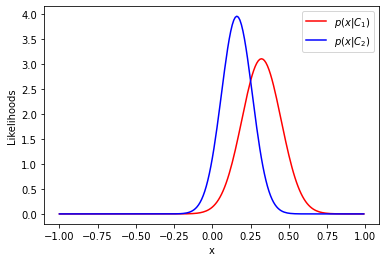

In [ ]:
from scipy.stats import norm
x_axis = np.arange(-1, 1, 0.01)
plt.plot(x_axis, norm.pdf(x_axis, best_parameters['m1'], best_parameters['s1']),'r')
plt.plot(x_axis, norm.pdf(x_axis, best_parameters['m2'], best_parameters['s2']),'b')
plt.xlabel('x')
plt.ylabel('Likelihoods')
plt.legend(['$p(x|C_1)$','$p(x|C_2)$'])
plt.show()

Since the two classes have different variances, posteriors will intersect at two points, as it is shown in the following graph.

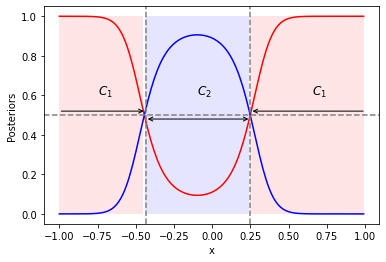

In [ ]:
# Calculations for Bayes'
pC1= y_train.sum() / y_train.size
pC2= 1-pC1
px_C1 = norm.pdf(x_axis, 0.320990, 0.128449)
px_C2 = norm.pdf(x_axis, 0.160143,  0.100812 )
px_C1 = norm.pdf(x_axis, 0.320990, 0.128449)
px_C2 = norm.pdf(x_axis, 0.160143,  0.100812 )
px = px_C1 * pC1 + px_C2 * pC2
pC1_x = px_C1 * pC1 / px
pC2_x = px_C2 * pC2 / px

## Plot
plt.plot(x_axis, pC1_x,'r')
plt.plot(x_axis, pC2_x,'b')
plt.axhline(y = 0.5, color = 'gray', linestyle = '--')
plt.axvline(x = 0.25, color = 'gray', linestyle = '--')
plt.axvline(x = -0.435, color = 'gray', linestyle = '--')
plt.text(-0.75, 0.6, '$C_1$', fontsize = 12)
plt.annotate('', xy=(-1, 0.52), xytext=(-0.435, 0.52),
            arrowprops=dict(arrowstyle='<-', color='black'))
plt.text(-0.1, 0.6, '$C_2$', fontsize = 12)
plt.annotate('', xy=(-0.435, 0.48), xytext=(0.25, 0.48),
            arrowprops=dict(arrowstyle='<->', color='black'))
plt.text(0.65, 0.6, '$C_1$', fontsize = 12)
plt.annotate('', xy=(0.25, 0.52), xytext=(1, 0.52),
            arrowprops=dict(arrowstyle='->', color='black'))
plt.xlabel('x')
plt.ylabel('Posteriors')
plt.fill_between(x_axis, 1, where=pC1_x > 0.5, facecolor='red', alpha=.1)
plt.fill_between(x_axis, 1, where=pC2_x > 0.5, facecolor='blue', alpha=.1)
plt.show()

#result = np.where((pC1_x - pC2_x <=0.05) & (pC1_x - pC2_x >=-0.05))   #How to find the intersections. Another alternative is to find the index of pC1 where pC1 is near to 0.5



# 2.
Now we are asked to take all the combinations of pair of features. 

In [ ]:
import itertools

def getPairs(X):
  return [ list(pair) for pair in list(itertools.combinations(list(X.columns), 2))]

For each pair of feautres we will model the classes as bivariate Gaussian distributions with a covariance matrix $\Sigma = I \sigma$, where $\sigma$ is a scalar, shared by all the classes. This is, the distribution for each class has a different mean but the same covariance matrix. 

To calculate the value of the shared diagonal covariance matrix parameter $\sigma$ for the bivariate Gaussian model with two features and two classes, we can calculate the sample variance of each feature separately across all the training samples and both classes and then take the average of the variances to obtain the value of $\sigma$. 

*Observation:* We take the average of the sample variances to obtain the value of the shared diagonal covariance matrix parameter $\sigma$ because we want to assume that the covariance between the two features is equal in both classes.

In [ ]:
def sameCovarianceCalculation(features,X):
  return (X[features[0]].var()+X[features[1]].var())/2
#sameCovarianceCalculation(pairs[0],X_train)

For each combination we need to estimate the parameters using the training dataset and evaluate the classifier in the validation dataset. Again, we can use the discriminant function $$g(x)= \log \dfrac{g_1(x)}{g_2(x)}$$ to predict the classes. As we know $$g_1(x)= \log p(C_1) p(x_1,x_2 | C_1)$$ and $$g_2(x)= \log p(C_2) p(x_1,x_2 | C_2),$$ then $$g(x)= \log \dfrac{p(C_1)}{p(C_2)} + \log \dfrac{p(x_1,x_2|C_1)}{p(x_1,x_2|C_2)}.$$ Our priors here are given by $$ p(x|C_i) = \dfrac{1}{2\pi \det(\Sigma)^{1/2}} \exp\left (-\dfrac{1}{2} (x-\mu_i)^T \Sigma^{-1}(x-\mu_i) \right).$$
Since $\Sigma = I\sigma$, $\det \Sigma =\sigma^2$, and $\Sigma^{-1} = I \dfrac{1}{\sigma}$, so the prior expression is $$p(x|C_i) = \dfrac{1}{2\pi \sigma} \exp\left (-\dfrac{1}{2\sigma} (x-\mu_i)^T(x-\mu_i) \right).$$
Then we get that $$g(x) = \log \dfrac{p(C_1)}{p(C_2)} - \dfrac{1}{2\sigma}(x-\mu_1)^T(x-\mu_1) + \dfrac{1}{2\sigma}(x-\mu_2)^T(x-\mu_2).$$ 
Simplifying,
$$g(x) = \log \dfrac{p(C_1)}{p(C_2)} - \dfrac{1}{2\sigma}\left(||x-\mu_1||^2 - ||x-\mu_2||^2 \right).$$ 

*Note:* Remember that here $\sigma$ does not mean the standard deviation.

In [ ]:
# The parameters in this case will be:
# * m1: the mean vector for the class 1
# * m2: the mean vector for the class 2
# * s: the parameter of the covariance matrix for the classes
def simpleBivariateGaussianParameters(features,X,C):
  return {
          'm1':np.array([mu(X[features[0]],C),mu(X[features[1]],C)]),
          'm2':np.array([mu(X[features[0]],1-C),mu(X[features[1]],1-C)]),
          's':sameCovarianceCalculation(features,X)
          }

# features: It is a list with the names of two features
# X: the full data
# C: the class dataframe
def simpleBivariateGaussianClassifier(features,X,C):
  params=simpleBivariateGaussianParameters(features,X,C)
  pC1= C.sum() / C.size
  pC2= 1-pC1
  return lambda df: (np.log(pC1/pC2)\
                    -(np.square(df.add(-params['m1'],axis='columns')).sum(axis=1)\
                      -np.square(df.add(-params['m2'],axis='columns')).sum(axis=1)\
                      )/(2*params['s'])) #>0).astype('int')

In [ ]:
def point2(X_train,y_train,X_valid,y_valid):
  pairs = getPairs(X_train)
  classifiers_metrics=dict()
  classifiers_params=dict()
  for pair in pairs:
    classifier=simpleBivariateGaussianClassifier(pair,X_train,y_train)
    params=simpleBivariateGaussianParameters(pair,X_train,y_train)
    y_predict= classifier(X_valid[pair]).apply(lambda x: x>0).astype('int')
    classifiers_metrics['-'.join(pair)]=evaluateClassifier(y_valid,y_predict)
    classifiers_params['-'.join(pair)]=params
  return {'metrics':classifiers_metrics,'parameters':classifiers_params}

results2=point2(X_train,y_train,X_valid,y_valid)
report(results2)


Parameters:
                              length-diameter  \
m1   [0.5870007082152975, 0.4611827195467422]   
m2  [0.46394300144300143, 0.3568650793650794]   
s                                    0.012064   

                                 length-height  \
m1   [0.5870007082152975, 0.16072946175637395]   
m2  [0.46394300144300143, 0.11909451659451659]   
s                                     0.008075   

                         length-whole_weight  \
m1  [0.5870007082152975, 1.0931738668555242]   
m2  [0.46394300144300143, 0.574403318903319]   
s                                   0.128774   

                         length-shucked_weight  \
m1    [0.5870007082152975, 0.4613601274787535]   
m2  [0.46394300144300143, 0.26276118326118325]   
s                                     0.032294   

                        length-viscera_weight  \
m1   [0.5870007082152975, 0.2378186968838527]   
m2  [0.46394300144300143, 0.1255551948051948]   
s                                     0.01315   

Let's compare the metrics.

In [ ]:
compare_metrics = pd.DataFrame(results2['metrics'])

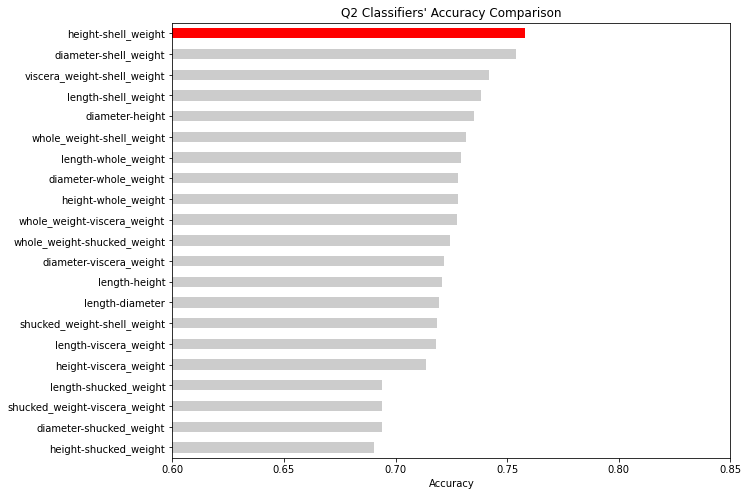

In [ ]:
plot_comparison(compare_metrics,'accuracy','Q2 Classifiers\'')

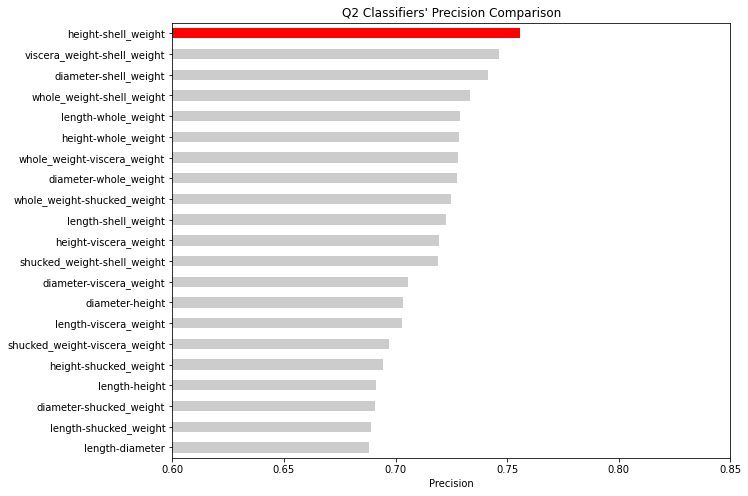

In [ ]:
plot_comparison(compare_metrics,'precision','Q2 Classifiers\'')

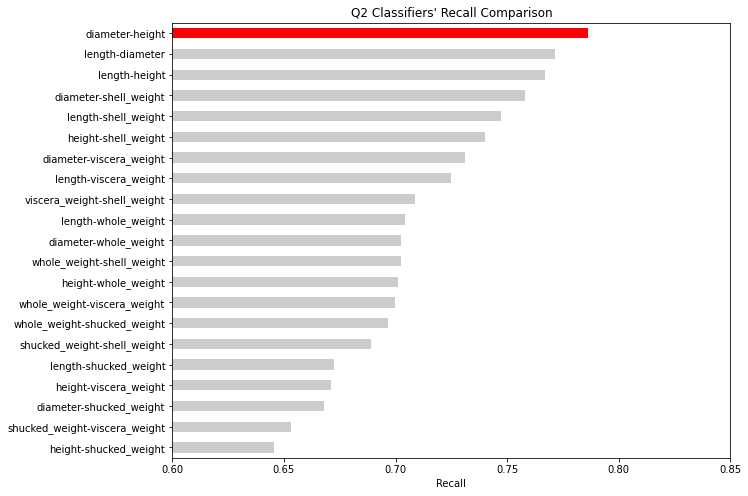

In [ ]:
plot_comparison(compare_metrics,'recall','Q2 Classifiers\'')

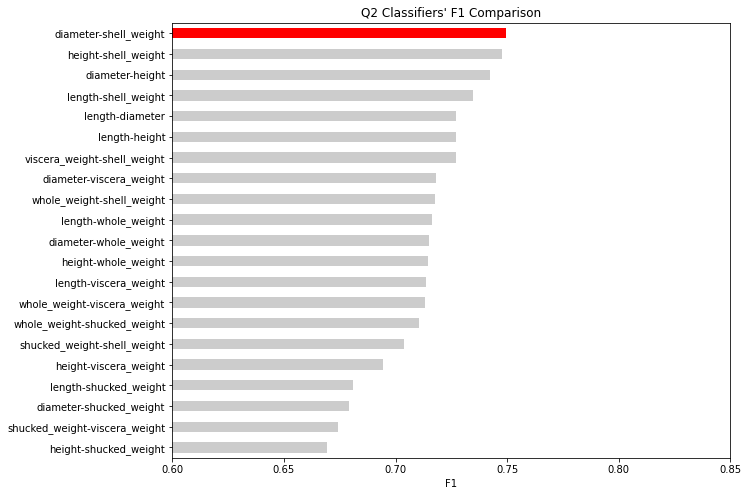

In [ ]:
plot_comparison(compare_metrics,'f1','Q2 Classifiers\'')

As previously stated, we will select the optimal classifier based on accuracy, leading us to choose the one associated with `height-shell_weight`. Notably, both `height` and `shell_weight` were identified as the top-performing classifiers in the previous point, and their combination yields the best classifier in this analysis. Interestingly, this holds true for all the other metrics evaluated, where the highest recall score in the previous point is achieved by combining the two attributes with the highest recall score in this point, and so forth.

In [ ]:
results2['parameters']['height-shell_weight']

{'m1': array([0.16072946, 0.32099044]),
 'm2': array([0.11909452, 0.16014322]),
 's': 0.010829964382726003}

In [ ]:
results2['metrics']['height-shell_weight']

{'accuracy': 0.7577955039883973,
 'precision': 0.7557251908396947,
 'recall': 0.7399103139013453,
 'f1': 0.7477341389728096}

We can now compare the top-performing result from the first point with that of the second.

In [ ]:
#I Added this another classifier for the first question, because something interesting happens
q1classifier=gaussianClassifier_aux(X_train['shell_weight'],y_train)


Let's compare their ROC-curves.

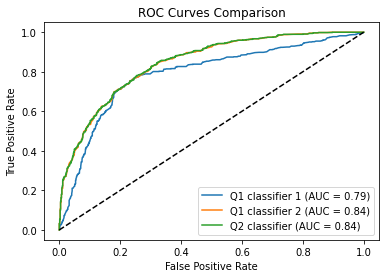

{'Q1 Classifier 1 AUC': 0.7873207857007516, 'Q1 Classifier 2 AUC': 0.8430524853154804, 'Q2 Classifier AUC': 0.8440640855596959}


In [ ]:
from sklearn.metrics import RocCurveDisplay, roc_curve, auc

classifier1=gaussianClassifier(X_train['shell_weight'],y_train)
y_predict1= (classifier1(X_valid['shell_weight']))#.apply(lambda x: 1 / (1 + np.exp(-x)))
y_predict1_aux=(q1classifier(X_valid['shell_weight']))#.apply(lambda x: 1 / (1 + np.exp(-x)))

classifier2=simpleBivariateGaussianClassifier(['height','shell_weight'],X_train,y_train)
y_predict2= classifier2(X_valid[['height','shell_weight']])#.apply(lambda x: 1 / (1 + np.exp(-x)))

fpr1, tpr1, th1 = roc_curve(y_valid, y_predict1)
fpr1_aux, tpr1_aux, th1_aux = roc_curve(y_valid, y_predict1_aux)
fpr2, tpr2, th2 = roc_curve(y_valid, y_predict2)
roc_auc1 = auc(fpr1, tpr1)
roc_auc1_aux = auc(fpr1_aux, tpr1_aux)
roc_auc2 = auc(fpr2, tpr2)


# create the RocCurveDisplay objects for each classifier
roc_display1 = RocCurveDisplay(fpr=fpr1, tpr=tpr1, roc_auc=roc_auc1, estimator_name='Q1 classifier 1')
roc_display1_aux = RocCurveDisplay(fpr=fpr1_aux, tpr=tpr1_aux, roc_auc=roc_auc1_aux, estimator_name='Q1 classifier 2')
roc_display2 = RocCurveDisplay(fpr=fpr2, tpr=tpr2, roc_auc=roc_auc2, estimator_name='Q2 classifier')

# plot both ROC curves on the same graph
ax = roc_display1.plot()
roc_display1_aux.plot(ax=ax.ax_)
roc_display2.plot(ax=ax.ax_)
plt.plot([0, 1], [0, 1], "k--")
# set the plot title and legend
plt.title('ROC Curves Comparison')

# show the plot
plt.show()
print({'Q1 Classifier 1 AUC': roc_auc1, 'Q1 Classifier 2 AUC':roc_auc1_aux, 'Q2 Classifier AUC': roc_auc2})

If we take into consideration the ROC curves and AUC values, happens something interesting. It is supposed that Q1 classifier 1 and Q1 classifier 2 are equivalent, but their ROC curves are so different. If we compare Q1 classifier 1 and Q2 classifier ROC curves, one can conclude that Q2 is by far a better classifier. But if we compare Q1 classifier 2 with Q2 classifier,  it suggests that they have similar performance in terms of true positive rate and false positive rate trade-offs, although Q2 performs slighly better.  

However, we can check the previous evaluation metrics to choose the best classifier and try to find out which ROC curve for the first question is the correct. 



In [ ]:
y_predict1_aux=(q1classifier(X_valid['shell_weight'])>0).astype('int')
pd.DataFrame({'Q1 Classifier 1':results['metrics']['shell_weight'], 'Q1 Classifier 2':evaluateClassifier(y_valid,y_predict1_aux),'Q2 Classifier':results2['metrics']['height-shell_weight']})

,Q1 Classifier 1,Q1 Classifier 2,Q2 Classifier
accuracy,0.759971,0.759971,0.757796
precision,0.775244,0.775244,0.755725
recall,0.711510,0.711510,0.739910
f1,0.742011,0.742011,0.747734


Based on the table, it can be observed that the Q1 classifiers have equal performing, indicating that they are equivalent. However, when compared with the Q2 classifier, it is noteworthy that the Q2 classifier exhibits slightly lower accuracy and precision, but it compensates for this with a higher recall and f1 score. Despite the minor differences between the three classifiers, their performance is pretty similar. Therefore, it can be concluded that the ROC curve of the Q1 classifier 2 is the correct one, and the differences between the ROC curves may be due to numerical approximation errors or similar factors.

Furthermore, even though the accuracy of the Q2 classifier is lower than that of the Q1 classifiers by only 0.002, its f1 score is 0.0057 better than its counterpart. This indicates that the Q2 classifier represents a good tradeoff between precision and recall, and can be considered superior to the Q1 classifiers, also considering their AUC values.

# 3
Now, we proceed to draw a plot for the `height-shell_weight` bivariate model, where the regions corresponding to the two classes are shown with different colores.

In [ ]:
from matplotlib.patches import Patch
from matplotlib.figure import Figure
from matplotlib.colors import ListedColormap



def plot_regions(classifier,features,limits={'x':[0,1,1000],'y':[0,1,1000]},title='',true_classifier=True):
  # Crear una figura y un eje
  x=np.linspace(limits['x'][0],limits['x'][1],limits['x'][2])
  y=np.linspace(limits['y'][0],limits['y'][1],limits['y'][2])
  fig= Figure()
  ax = fig.subplots()
  xx,yy=np.meshgrid(x,y)
  if true_classifier:
    zz= classifier(pd.DataFrame({features[0]:xx.flatten(),features[1]:yy.flatten()}))
  else:
    zz= classifier(pd.DataFrame({features[0]:xx.flatten(),features[1]:yy.flatten()})).apply(lambda x: x>0).astype('int')
  zz=np.array(zz).reshape(xx.shape)
  fig, ax = plt.subplots()

  #colors = ['red', 'blue']
  #cmap = ListedColormap(colors[:len(np.unique(zz))])
  cmap = plt.colormaps['Pastel1']
  list_of_colors=[cmap.colors[0], cmap.colors[1],cmap.colors[2]]
  new_cmap = ListedColormap(list_of_colors)  
  pcm=ax.pcolormesh(xx,yy,zz,cmap=new_cmap)
  
  #colors = [colormap(i) for i in np.unique(zz)]

  ax.set_xlabel(features[0])
  ax.set_ylabel(features[1])
  ax.set_title(title)

  # Agregar leyenda
  if len(np.unique(zz))==2:
    aux=[new_cmap(0),new_cmap(2)]
    patches = [Patch(color=aux[i], label='Class {}'.format(np.unique(zz)[i])) for i in range(len(np.unique(zz)))]
  else:
    patches = [Patch(color=new_cmap(i), label='Class {}'.format(np.unique(zz)[i])) for i in range(len(np.unique(zz)))]
    
  ax.legend(handles=patches,loc='center left',bbox_to_anchor=(1, 0.5))
  # Mostrar la figura
  return fig,ax,new_cmap



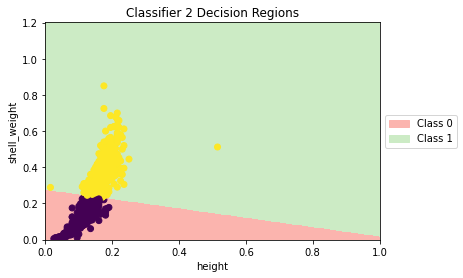

In [ ]:
fig,ax,_=plot_regions(classifier2,['height','shell_weight'],limits={'x':[0,1,500],'y':[0,1.2,500]},title='Classifier 2 Decision Regions',true_classifier=False);
y_aux=y_predict2>0
ax.scatter(X_valid['height'], X_valid['shell_weight'], c=y_aux)

plt.show(fig)


We can notice from the graph that the decision boundary is a line and in fact it must be one. Remember that $$g(x) = \log \dfrac{p(C_1)}{p(C_2)} - \dfrac{1}{2\sigma}(x-\mu_1)^T(x-\mu_1) + \dfrac{1}{2\sigma}(x-\mu_2)^T(x-\mu_2).$$  This can be expressed as 
$$g(x) = \log \dfrac{p(C_1)}{p(C_2)} - \dfrac{1}{2\sigma}(x^Tx - 2\mu_1^T x+ \mu_1^T\mu_1) + \dfrac{1}{2\sigma}(x^Tx - 2\mu_2 x+ \mu_2^T\mu_2).$$ 
Then 
$$g(x) = \log \dfrac{p(C_1)}{p(C_2)} - \dfrac{1}{2\sigma}(x^Tx - 2\mu_1^T x+ \mu_1^T\mu_1 -(x^Tx - 2\mu_2^T x+ \mu_2^T\mu_2)).$$ 
Simplifying,
$$g(x) = \log \dfrac{p(C_1)}{p(C_2)} - \dfrac{1}{2\sigma}(- 2\mu_1^T x+ \mu_1^T\mu_1 + 2\mu_2^T x - \mu_2^T\mu_2)).$$
Finally, we get the following expression
$$g(x) = \log \dfrac{p(C_1)}{p(C_2)} - \dfrac{1}{2\sigma}(\mu_1^T\mu_1 - \mu_2^T\mu_2) + \dfrac{1}{\sigma} ( \mu_1-\mu_2)^Tx.$$
It is the expression of a line in $\mathbb{R}^2$, explicitly,
$g(x) = w_0 + w_1^T x$, where $w_0=\log \dfrac{p(C_1)}{p(C_2)} - \dfrac{1}{2\sigma}(\mu_1^T\mu_1 - \mu_2^T\mu_2)$ and $w_1=\dfrac{1}{\sigma} ( \mu_1-\mu_2)$. 
Replacing the values we got for the parameters of the best classifier ($\mu_1=(0.16073, 0.320993)$, $\mu_2=(0.119093, 0.160143)$, and $\sigma = 0.01083 $ ), 
we obtain,


In [ ]:
pC1= y_train.sum() / y_train.size
pC2= 1-pC1
best2=results2['parameters']['height-shell_weight']
w0=np.log(pC1/pC2) - (1/(2*best2['s']))*(np.dot(best2['m1'],best2['m1'])-np.dot(best2['m2'],best2['m2']))
w1=(1/best2['s']) * (best2['m1']-best2['m2'])
print(f'w0={w0} and w1={list(w1)}')

w0=-4.092207032069451 and w1=[3.844421245582847, 14.852054495841266]


Since our decision boundary lies where $g(x)=0$, $$-4.09221
 + (3.8444,14.8520)^T (x_1,x_2) = 0.$$
Then, $$x_2 = -0.27553 -0.25884 x_1.$$

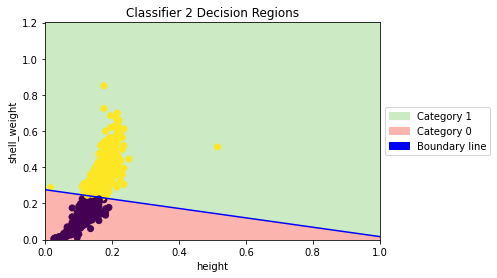

In [ ]:
m=-w1[0]/w1[1]
b=-w0/w1[1]
x1= np.linspace(0,1,100)
x2= m*x1+b

fig,ax,colors=plot_regions(classifier2,['height','shell_weight'],limits={'x':[0,1,500],'y':[0,1.2,500]},title='Classifier 2 Decision Regions',true_classifier=False);
line_color='blue'
ax.plot(x1, x2, color=line_color)

ax.scatter(X_valid['height'], X_valid['shell_weight'], c=y_aux)
legend_elements = [Patch(color=colors(2), label='Category 1'),
                  Patch(color=colors(0), label='Category 0'),
                  Patch(color=line_color, linestyle='-',label='Boundary line')
                   ]
ax.legend(handles=legend_elements,loc='center left',bbox_to_anchor=(1, 0.5))

plt.show()

# 4

Using the best combination of parameters found in question 2, we are asked to build a bivariate classifier, but this time the covariance matrix could be an arbitrary matrix (not diagonal) and different for each class.

Remember that our discriminant function is $$g(x)= \log \dfrac{p(C_1)}{p(C_2)} + \log \dfrac{p(x_1,x_2|C_1)}{p(x_1,x_2|C_2)},$$ and our priors here are given by $$ p(x|C_i) = \dfrac{1}{2\pi \det(\Sigma_i)^{1/2}} \exp\left (-\dfrac{1}{2} (x-\mu_i)^T \Sigma_i^{-1}(x-\mu_i) \right).$$
We have to estimate both $\mu_i$ and $\Sigma_i$, for $i=1,2$.

In [ ]:
# The parameters in this case will be:
# * m1: the mean vector for the class 1
# * m2: the mean vector for the class 2
# * s: Covariance matrix
def bivariateGaussianParameters(features,X,C):
  data=pd.merge(X[features],C, left_index=True, right_index=True)
  return {
          'm1':data[features][data['ringClass']==1].mean(),
          'm2':data[features][data['ringClass']==0].mean(),
          'Sigma1': data[features][data['ringClass']==1].cov(),
          'Sigma2': data[features][data['ringClass']==0].cov(),
          }

# features: It is a list with the names of two features
# X: the full data
# C: the class dataframe
def bivariateGaussianClassifier(features,X,C, reject_parameter=2.):
  params=bivariateGaussianParameters(features,X,C)
  pC1= C.sum() / C.size
  pC2= 1-pC1

  def pCi_x(df,mu,Sigma,pCi):
    detSigma=np.linalg.det(Sigma)
    invSigma=np.linalg.inv(Sigma)
    x_mu=df.add(-mu,axis='columns') #x - mu
    x_muSigma=np.matmul(x_mu,invSigma)
    x_muSigma.columns=features
    df1=-0.5*x_muSigma.multiply(x_mu).sum(axis=1) #everything inside the exponential
    return pCi*(1/(2*np.pi*np.sqrt(detSigma)))*(df1.apply(lambda x: np.exp(x)))

  def choose(df):
    pC1_x=pCi_x(df,params['m1'],params['Sigma1'],pC1)
    pC2_x=pCi_x(df,params['m2'],params['Sigma2'],pC2)
    rp=1-reject_parameter
    ans=(pC1_x.copy())*0
    px=pC1_x + pC2_x
    auxpC1=pC1_x.div(px) #True bayes
    auxpC2=pC2_x.div(px) #True bayes
    ans[(pC1_x>pC2_x)&(auxpC1>=rp)]=1
    ans[(pC1_x<pC2_x)&(auxpC2>=rp)]=0
    ans[(auxpC1<rp)|(auxpC2<rp)|(pC1_x==pC2_x)]=-1
    #ans[pC1_x>pC2_x]=1
    return ans
  return choose 

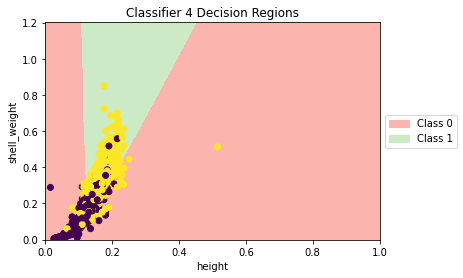

In [ ]:
features=['height','shell_weight']
classifier4=bivariateGaussianClassifier(features,X_train,y_train, reject_parameter=2)
y_predict4= classifier4(X_valid[features])

fig,ax,colors=plot_regions(classifier4,['height','shell_weight'],limits={'x':[0,1,500],'y':[0,1.2,500]},title='Classifier 4 Decision Regions',true_classifier=False);
ax.scatter(X_valid['height'], X_valid['shell_weight'], c=y_valid)
plt.show()


Upon observing the results, it becomes evident that the classifier from the second question has a linear behavior, whereas the current classifier appears to be non-linear. Specifically, the region containing class 1 seems to have a quadratic shape, suggesting that the classifier operates on a quadratic model. This can be inferred from the rotated parabolic shape of the region in question, or a rotated hyperbolic shape. 

*Note:* It can be proved that, in general, this kind of classifier is hyperquadratic [Reference: Pattern Classification, Duda 2001].

The classifier above also includes the possibility of rejection by adding the parameter `reject_parameter`. This parameter accepts values ranging from 0 to 1, allowing for fine-tuning of the rejection criteria. It should be noted that values close to 0 for the reject_parameter parameter tend to result in a highly restrictive rejection criteria, rejecting a vast majority of inputs. Conversely, values near 1 indicate a more lenient acceptance criteria, accepting nearly all inputs. In the event that the set rejection criteria are met, the corresponding class value will be marked as -1. As an example, suppose we assign a value of 0.6 to the  `reject_parameter` parameter:

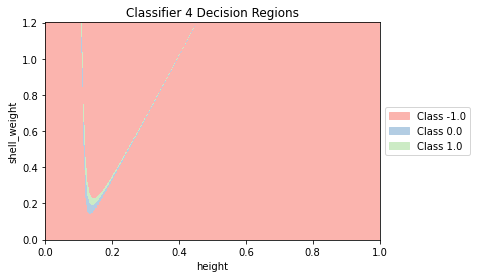

In [ ]:
features=['height','shell_weight']
classifier4=bivariateGaussianClassifier(features,X_train,y_train, reject_parameter=0.6)
y_predict4= classifier4(X_valid[features])

fig,ax,colors=plot_regions(classifier4,['height','shell_weight'],limits={'x':[0,1,500],'y':[0,1.2,500]},title='Classifier 4 Decision Regions',true_classifier=True);

It appears that the current rejection criteria may be excessively stringent. To test this hypothesis, we can adjust the reject_parameter parameter to a value closer to 1, such as 0.95, and observe the results.

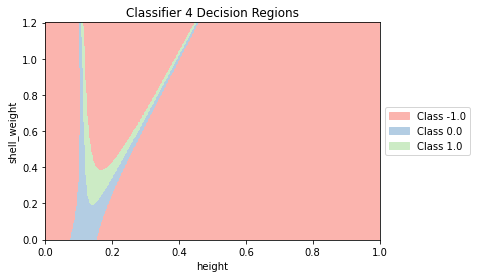

In [ ]:
classifier4=bivariateGaussianClassifier(features,X_train,y_train, reject_parameter=0.95)
fig,ax,colors=plot_regions(classifier4,['height','shell_weight'],limits={'x':[0,1,500],'y':[0,1.2,500]},title='Classifier 4 Decision Regions',true_classifier=True);

It is worth noting that even when the reject_parameter parameter is set to a value as high as 0.95, the rejection criteria remains considerably strict. To explore this further, we can increase the value of reject_parameter to 0.99, 0.999999999, and 1, and  observe the impact on the results. Based on the information presented in this figure, it appears that the shape of the classifier's region is not a parabola as previously thought. Instead, it resembles a hyperbola.

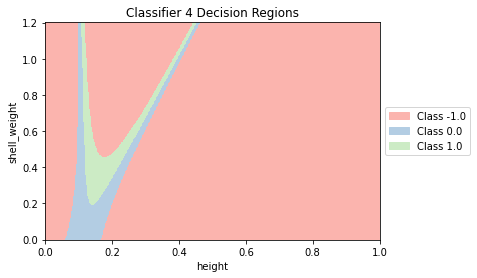

In [ ]:
classifier4=bivariateGaussianClassifier(features,X_train,y_train, reject_parameter=0.99)
fig,ax,colors=plot_regions(classifier4,['height','shell_weight'],limits={'x':[0,1,500],'y':[0,1.2,500]},title='Classifier 4 Decision Regions',true_classifier=True);
#ax.scatter(X_valid['height'], X_valid['shell_weight'], c=y_valid)
#plt.show()

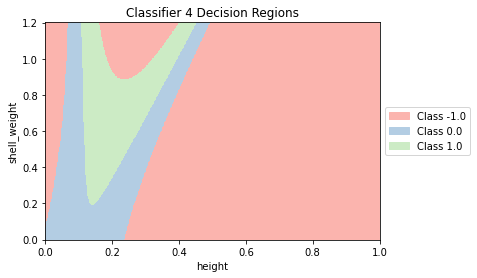

In [ ]:
classifier4=bivariateGaussianClassifier(features,X_train,y_train, reject_parameter=0.999999999)
fig,ax,colors=plot_regions(classifier4,['height','shell_weight'],limits={'x':[0,1,500],'y':[0,1.2,500]},title='Classifier 4 Decision Regions',true_classifier=True);
#ax.scatter(X_valid['height'], X_valid['shell_weight'], c=y_valid)
#plt.show()

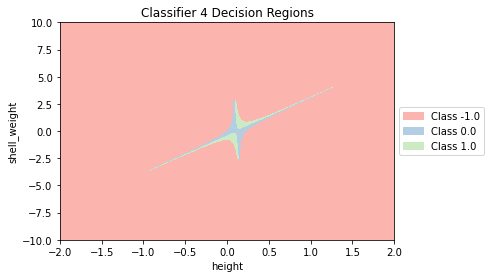

In [ ]:
classifier4=bivariateGaussianClassifier(features,X_train,y_train, reject_parameter=0.999999999)
fig,ax,colors=plot_regions(classifier4,['height','shell_weight'],limits={'x':[-2,2,1000],'y':[-10,10,1000]},title='Classifier 4 Decision Regions',true_classifier=True);

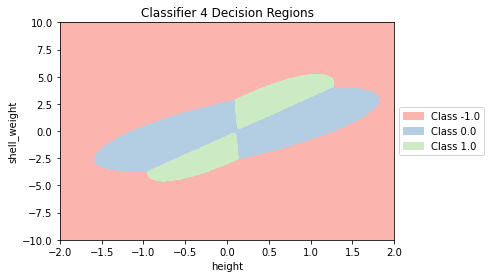

In [ ]:
classifier4=bivariateGaussianClassifier(features,X_train,y_train, reject_parameter=1)
fig,ax,colors=plot_regions(classifier4,['height','shell_weight'],limits={'x':[-2,2,1000],'y':[-10,10,1000]},title='Classifier 4 Decision Regions',true_classifier=True);

Upon experimentation, it has become apparent that even a reject_parameter value of 0.99 may prove to be excessively restrictive. However, setting the reject_parameter value to 0.9999999 appears to be a better fit, and further increasing it to 1 results in accepting all inputs. This observation highlights the sensitivity of the classifier to values near 1, particularly when the value is in close proximity to 1.

Upon relaxing the constraints on the feature values, it is evident that the shape of the classification regions conforms to an approximately hyperbolic shape, which appears to be restricted by a parabolic boundary.

It would be informative to compare the metrics of the second classifier and the last one without the rejection option.

In [ ]:
classifier4=bivariateGaussianClassifier(features,X_train,y_train, reject_parameter=1)
y_predict4=classifier4(X_valid[['height','shell_weight']])

pd.DataFrame({'Q1 Classifier':results['metrics']['shell_weight'],'Q2 Classifier':results2['metrics']['height-shell_weight'],'Q4 Classifier':evaluateClassifier(y_valid,y_predict4)})

,Q1 Classifier,Q2 Classifier,Q4 Classifier
accuracy,0.759971,0.757796,0.745468
precision,0.775244,0.755725,0.719613
recall,0.711510,0.739910,0.778774
f1,0.742011,0.747734,0.748026


Among the three classifiers, Q2 has the highest accuracy of 0.757796, followed by Q4 with 0.745468, and Q1 with 0.744017. Therefore, based on accuracy alone, we would choose Q2 as the best classifier.

However, accuracy is not always the best metric to evaluate a classifier, especially when the classes are imbalanced. In this case, we know that the classes are balanced, but we do not know well about the interpretation of the classes, so we should also have into consideration the other metrics.

* Precision measures the percentage of true positives out of all predicted positives. It is a useful metric when we want to avoid false positives. Among the three classifiers, Q1 has the highest precision of 0.793680, followed by Q2 with 0.755725, and Q4 with 0.719613.

* Recall measures the percentage of true positives out of all actual positives. It is a useful metric when we want to avoid false negatives. Among the three classifiers, Q4 has the highest recall of 0.778774, followed by Q2 with 0.739910, and Q1 with 0.638266.

* F1 score is the harmonic mean of precision and recall. It is a good metric to consider when we want to balance both precision and recall. Among the three classifiers, Q4 has the highest F1 score of 0.748026, followed by Q2 with 0.747734, and Q1 with 0.707539.

Overall, based on the presented metrics, we can conclude that Q2 and Q4 are the best classifiers. And it is reasnonable, because we are including the information of two features instead of a single one.  Q2 has the highest accuracy and a relatively high precision, while Q4 has the highest recall and F1 score. The choice between Q2 and Q4 ultimately depends on the specific needs and goals of the classification task. 

# Adding some interpretation to the classes

In order to analyze which classifier is superior, we need to establish some context. Initially, we have two categories based on the number of rings on abalones. In this context, it is reasonable to define the correct interpretation of the classification as follows: classifying 0 if the abalone is young and 1 if the abalone is old. For simplicity and pedagogical purposes, we will consider only the classifiers shown in the previous exercise to show why it is important to know the context and the objectives before to do anything else. 

### First Context: Sustainable harvest
By classifying abalones as young or old, we can assess the productivity and health of the population, and make informed decisions about sustainable harvest levels and conservation efforts.
In this context, the most important metric to consider is likely recall. This is because false negatives (i.e., old abalones classified as young) could lead to underestimation of the population size and productivity, which could result in unsustainable harvest levels and potentially harm the population in the long term. Based on the previous metrics, Q4 has the highest recall (0.778774) and may be the best classifier.

### Second context: Abalones as a food source
The age of an abalone can also impact its nutritional value and taste. Some people believe that older abalones are tougher and less flavorful, while younger abalones are more tender and flavorful.
If the goal is to provide more accurate information to consumers and help ensure that they are getting the type of abalone that they prefer, the most important metric to consider is likely precision. This is because false positives (i.e., young abalones classified as old) could lead to consumer dissatisfaction if they are expecting a certain type of abalone based on its age. Considering this, Q1 has the highest precision (0.775244), which suggests that it is the most effective at identifying old abalones while minimizing false positives (i.e., young abalones classified as old), and could be the best classifier.

### Third context: Research
Classifying abalones as young or old can also be important for research purposes. By studying the growth and development patterns of abalones at different ages, we can gain a better understanding of their biology and ecology, and develop more effective management and conservation strategies.
Here, the most important metric to consider is likely F1 score, which balances precision and recall. This is because both false positives and false negatives can lead to inaccurate research findings and potentially harm the abalone population in the long term. Since Q4 has the highest F1 score (0.748026), it could be considered a good choice. However if we consider that Q2 has a similar F1 score (0.747734), and a much better accuracy than Q4 (over 0,012328), we should say that Q2 is the best classifier in this case.
